In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display

# Movie Reviews Sentiment Analysis

## Dataset

In [2]:
from keras.datasets import imdb

# dataset set: 
#     + X: 25000 trainning paragraphs, 25000 Testing paragraphs
#          each word is mapped as a number
#     + y: 0 or 1
(X_train, y_train), (X_test, y_test) = imdb.load_data(
    '/tmp/imdb.npz',
    num_words=None,
    skip_top=0,
    maxlen=None,
    start_char=1,
    oov_char=2,
    index_from=3)

print(X_train.shape)
print(y_train.shape)
print('')
print(X_test.shape)
print(y_test.shape)


# idx: A dictionary map word -> num
#     Eg: 
#         {'fawn': 34701,
#          'tsukino': 52006,
#          'nunnery': 52007,
#          'sonja': 16816,
#          'vani': 63951,
#          'woods': 1408,
#          ...}
idx = imdb.get_word_index()

Using TensorFlow backend.


(25000,)
(25000,)

(25000,)
(25000,)


In [3]:
print(len(X_train[0]))
print(y_train[0])

218
1


In [4]:
print(len(X_train[1]))
print(y_train[1])

189
0


### Construct a review

In [5]:
# Create reverse index: map num->word
#     Eg:
#         {34704: 'fawn',
#          52009: 'tsukino',
#          52010: 'nunnery',
#          16819: 'sonja',
#          63954: 'vani',
#          1411: 'woods',
#          ...}
rev_idx = {v+3:k for k,v in idx.items()}
rev_idx[0] = 'padding_char'
rev_idx[1] = 'start_char'
rev_idx[2] = 'oov_char'
rev_idx[3] = 'unk_char'

In [6]:
# Construct a paragraph from X_train[0]
example_review = ' '.join([rev_idx[word] for word in X_train[0]])

display(example_review)
print(y_train[0])

"start_char this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and

1


In [7]:
# Construct a paragraph from X_train[1
example_review = ' '.join([rev_idx[word] for word in X_train[1]])

display(example_review)
print(y_train[1])

"start_char big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal measures the hair is big lots of boobs bounce men wear those cut tee shirts that show off their stomachs sickening that men actually wore them and the music is just synthesiser trash that plays over and over again in almost every scene there is trashy music boobs and paramedics taking away bodies and the gym still doesn't close for bereavement all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back the

0


## Feature Engineerings

### Normalize the size of X

In [8]:
# Each paragraph has different length
print(len(X_train[0]))
print(len(X_train[1]))
print(len(X_train[2]))
print('')
print(X_train.shape)
print(X_test.shape)

218
189
141

(25000,)
(25000,)


In [9]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train_pad = pad_sequences(X_train, maxlen=maxlen)
X_test_pad = pad_sequences(X_test, maxlen=maxlen)

print(len(X_train_pad[0]))
print(len(X_train_pad[1]))
print(len(X_train_pad[2]))
print('')
print(X_train_pad.shape)
print(X_test_pad.shape)

100
100
100

(25000, 100)
(25000, 100)


# Model

### Find the maximum number of features
- Find the maximum number that represent a word

In [10]:
max_features = max([max(x) for x in X_train_pad] + 
                   [max(x) for x in X_test_pad]) + 1
max_features

88587

### Model

In [11]:
from keras.layers import LSTM, Dense, Embedding
from keras.models import Sequential

model = Sequential()

model.add(Embedding(
    input_dim=max_features,  # input = a number in range 0-max_features
    output_dim=128))         # output = 128D vector
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         11339136  
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 11,388,609
Trainable params: 11,388,609
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(
    X_train_pad, y_train,
    batch_size=32, epochs=2, validation_split=0.3)

Train on 17500 samples, validate on 7500 samples
Epoch 1/2
17500/17500 [==============================] - 249s 14ms/step - loss: 0.4854 - acc: 0.7669 - val_loss: 0.3918 - val_acc: 0.8297
Epoch 2/2
17500/17500 [==============================] - 263s 15ms/step - loss: 0.2755 - acc: 0.8914 - val_loss: 0.3760 - val_acc: 0.8411


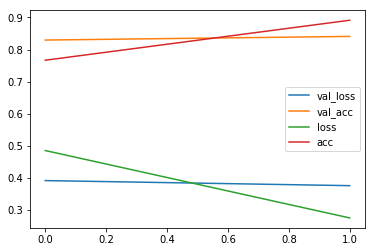

In [13]:
historydf = pd.DataFrame(history.history, index=history.epoch)
historydf.plot();

## Evaluate

In [14]:
score, acc = model.evaluate(X_test_pad, y_test)

print('Test score:', score)
print('Test accuracy:', acc)

25000/25000 [==============================] - 30s 1ms/step
Test score: 0.38075914932250976
Test accuracy: 0.83948
